# SEP 740 Project (Fall 2023)
**by Manit Janjua, Eric Morris, Varun Rajput (Group 1)**

**W Booth School of Engineering Practice and Technology, McMaster University**


### Importing Libraries

In [ ]:
from datetime import datetime
import yfinance as yf
from pandas_datareader import data as pdr

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.utils import plot_model

!pip install keras-tuner
from keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

yf.pdr_override()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.2 MB/s eta 0:00:00


<ipython-input-1-e6b4ef3f3c2a>:23: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


### Data Loading

In [ ]:
# Using Yahoo Finance library to load the stock of choice

# https://ca.finance.yahoo.com/quote/AMZN/
stock = 'AMZN'

# Give the start date and end date
end = datetime.now()
start = datetime(end.year - 5, end.month, end.day)

data = pdr.get_data_yahoo(stock, start, end)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-04,145.250000,145.350006,142.809998,144.839996,144.839996,48294200
2023-12-05,143.550003,148.570007,143.130005,146.880005,146.880005,46822400
2023-12-06,147.580002,147.850006,144.279999,144.520004,144.520004,39679000
2023-12-07,146.149994,147.919998,145.339996,146.880005,146.880005,52352800
2023-12-08,145.479996,147.839996,145.399994,147.419998,147.419998,41858000


In [ ]:
data.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

### Data Analysis

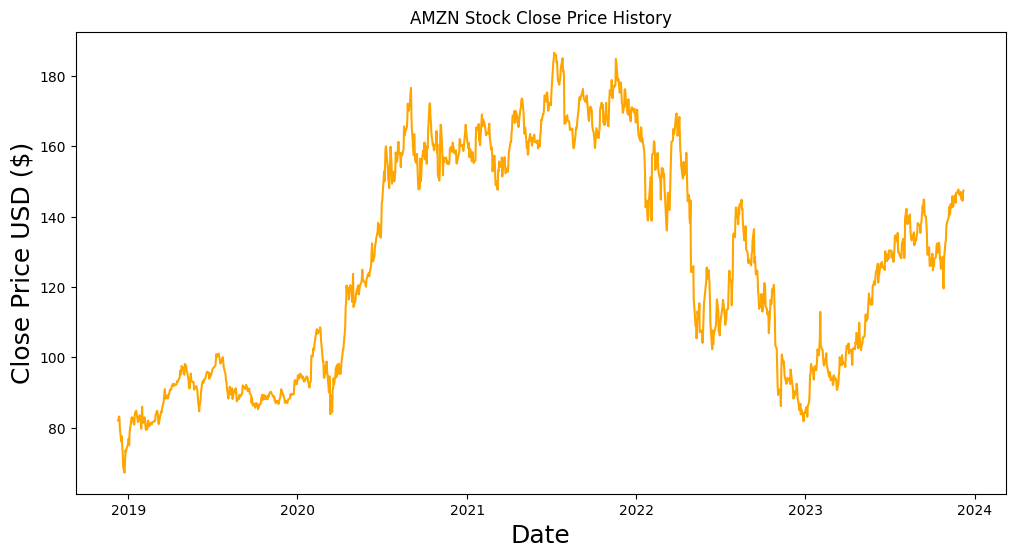

In [ ]:
# Stock closing price over the given period of time

plt.figure(figsize=(12, 6))
plt.title(stock + ' Stock Close Price History')
plt.plot(data['Close'], label = 'Close Price', color = 'orange')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price USD ($)', fontsize = 18)
plt.show()

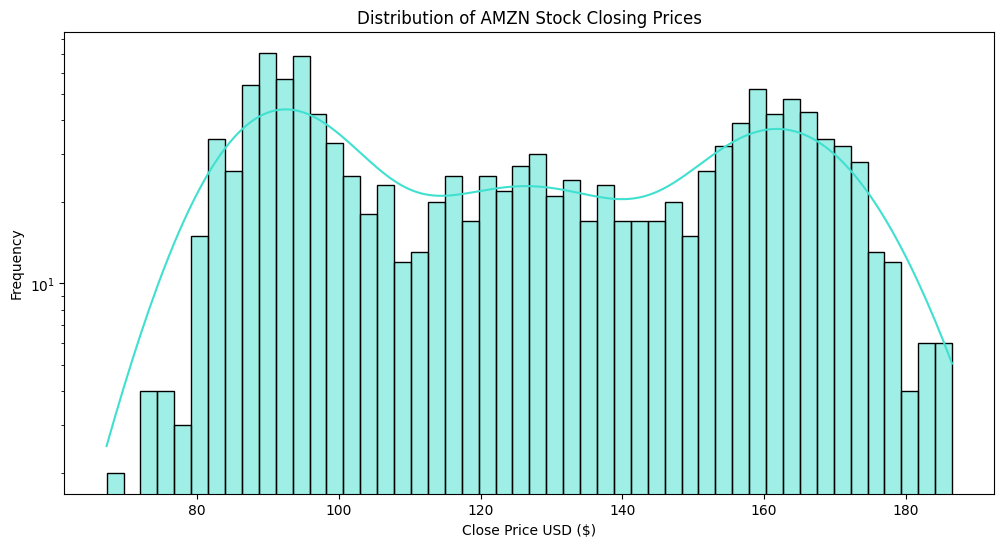

In [ ]:
# Distribution of stock closing prices

plt.figure(figsize=(12, 6))
sns.histplot(data['Close'], bins=50, kde=True, color='turquoise')
plt.yscale('log')  # Use a log scale on the y-axis
plt.title('Distribution of ' + stock + ' Stock Closing Prices')
plt.xlabel('Close Price USD ($)')
plt.ylabel('Frequency')
plt.show()

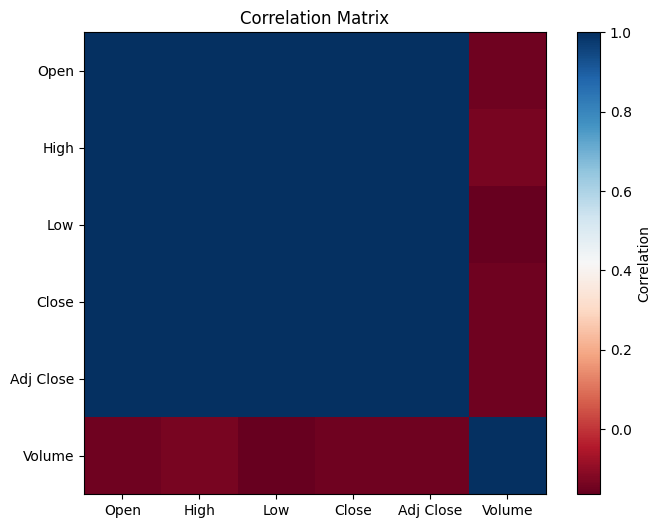

In [ ]:
correlation_matrix = data.corr()

# Plotting the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix, cmap='RdBu', interpolation='nearest')
plt.colorbar(label='Correlation')
plt.title('Correlation Matrix')
plt.xticks(ticks=np.arange(len(data.columns)), labels=data.columns)
plt.yticks(ticks=np.arange(len(data.columns)), labels=data.columns)
plt.show()

### Data Pre-Processing

In [ ]:
# Train-Test splitting

# Number of days to consider for each prediction
sequence_length = 5

# Scaling close prices
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

# Determining the length of the training data
training_data_len = int(len(data) * 0.8)  # 80% of the data for training

# Creating the training data set
train_data = scaled_data[0:training_data_len, :]
x_train, y_train = [], []

for i in range(sequence_length, len(train_data)):
    x_train.append(train_data[i-sequence_length:i, 0])
    y_train.append(train_data[i, 0])

# Converting the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

print(pd.DataFrame(x_train))
pd.DataFrame(x_train)

# Reshaping the data for LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Prepare the testing data set
test_data = scaled_data[training_data_len - sequence_length:, :]
x_test = []
y_test = data['Close'][training_data_len:].values

for i in range(sequence_length, len(test_data)):
    x_test.append(test_data[i - sequence_length:i, 0])

# Convert the data to a numpy array and reshape for LSTM
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

             0         1         2         3         4
0     0.124430  0.125356  0.133858  0.131697  0.103856
1     0.125356  0.133858  0.131697  0.103856  0.074117
2     0.133858  0.131697  0.103856  0.074117  0.086921
3     0.131697  0.103856  0.074117  0.086921  0.063298
4     0.103856  0.074117  0.086921  0.063298  0.048952
...        ...       ...       ...       ...       ...
997   0.225613  0.219582  0.224105  0.211288  0.245802
998   0.219582  0.224105  0.211288  0.245802  0.237090
999   0.224105  0.211288  0.245802  0.237090  0.225613
1000  0.211288  0.245802  0.237090  0.225613  0.199476
1001  0.245802  0.237090  0.225613  0.199476  0.176356

[1002 rows x 5 columns]


## Model Building

In [ ]:
# Finding the best model and performing hyperparameter tuning
# TODO: 1. Change sequence length - auto correlation & partial correlation
# TODO: 2. Add more features like days of the year, etc
# TODO: 3. Plot loss vs number of epochs

def build_model(hp):
    model = Sequential()

    model.add(LSTM(units=hp.Int('units', min_value=16, max_value=128, step=16),
                   return_sequences=True,
                   input_shape=(x_train.shape[1], x_train.shape[2]))) # 8 options for units
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1))) # 5 options for dropout rate

    model.add(LSTM(units=hp.Int('units_2', min_value=8, max_value=128, step=8),
                   return_sequences=False)) # 16 options for units
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1))) # 5 options for dropout rate

    model.add(Dense(units=hp.Int('units_3', min_value=16, max_value=64, step=16),
                    activation=hp.Choice('dense_activation', values=['relu', 'sigmoid', 'tanh', 'linear']))) # 4 options for activation function

    model.add(Dense(1))

    # Choose between Adam and SGD optimizers
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'sgd']) # 2 options for optimizer

    # Choose learning rate for the optimizer
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]) # 3 options for learning rate

    if optimizer_choice == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)


    model.compile(optimizer=optimizer,
                  loss=hp.Choice('loss_function', values=['mse', 'mae']),
                  metrics=['mse']) # 2 options for loss function

    return model

# Instantiate the tuner with early stopping
tuner = RandomSearch(
    build_model,
    objective='mse',
    max_trials=25, # ideally this number would be a lot higher due to 4800 possible combination of tuned parameters
    executions_per_trial=1,
    directory='my_dir',
    project_name='lstm_regression_single_input_tuning_early_stopping'
)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', min_delta=0.001)

# Perform hyperparameter search with early stopping
tuner.search(x_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Summary of the best model architecture
best_model.summary()

Trial 25 Complete [00h 00m 06s]
mse: 0.004386278335005045

Best mse So Far: 0.0018941410817205906
Total elapsed time: 00h 04m 11s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 112)            51072     
                                                                 
 dropout (Dropout)           (None, 5, 112)            0         
                                                                 
 lstm_1 (LSTM)               (None, 88)                70752     
                                                                 
 dropout_1 (Dropout)         (None, 88)                0         
                                                                 
 dense (Dense)               (None, 32)                2848      
                                                                 
 dense_1 (Dense)             (None, 1)                 33 

Best Hyperparameters:
Number of LSTM units in the first layer: 112
Dropout rate in the first LSTM layer: 0.30000000000000004
Number of LSTM units in the second layer: 88
Dropout rate in the second LSTM layer: 0.2
Number of units in the dense layer: 32
Best Learning rate: 0.01
Best Dense Activation Function:  sigmoid
Best Optimizer: adam
Best Compile Loss Function: mse


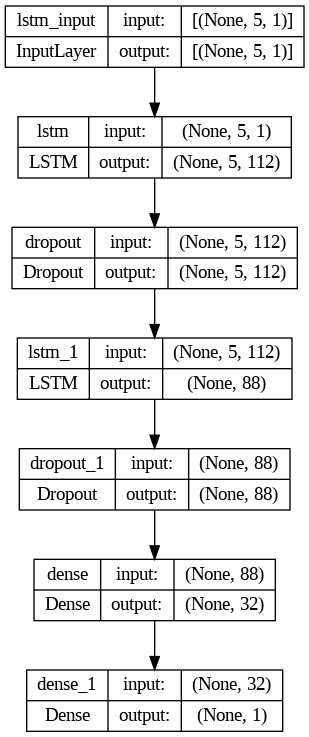

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_dense_activation = best_hps.get('dense_activation')
best_optimizer = best_hps.get('optimizer')
best_learning_rate = best_hps.get('learning_rate')
best_loss_function = best_hps.get('loss_function')

print("Best Hyperparameters:")
print(f"Number of LSTM units in the first layer: {best_hps.get('units')}")
print(f"Dropout rate in the first LSTM layer: {best_hps.get('dropout')}")
print(f"Number of LSTM units in the second layer: {best_hps.get('units_2')}")
print(f"Dropout rate in the second LSTM layer: {best_hps.get('dropout_2')}")
print(f"Number of units in the dense layer: {best_hps.get('units_3')}")
print(f"Best Learning rate: {best_hps.get('learning_rate')}")
print("Best Dense Activation Function: ", best_dense_activation)
print("Best Optimizer:", best_optimizer)
print("Best Compile Loss Function:", best_loss_function)

plot_model(best_model, show_shapes=True, show_layer_names=True)

## Model Evaluation

In [ ]:
# Get the model's predicted price values
predictions = best_model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

8/8 [==============================] - 0s 4ms/step


<ipython-input-17-2fe70d03f9d4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions.flatten()  # Flatten predictions array


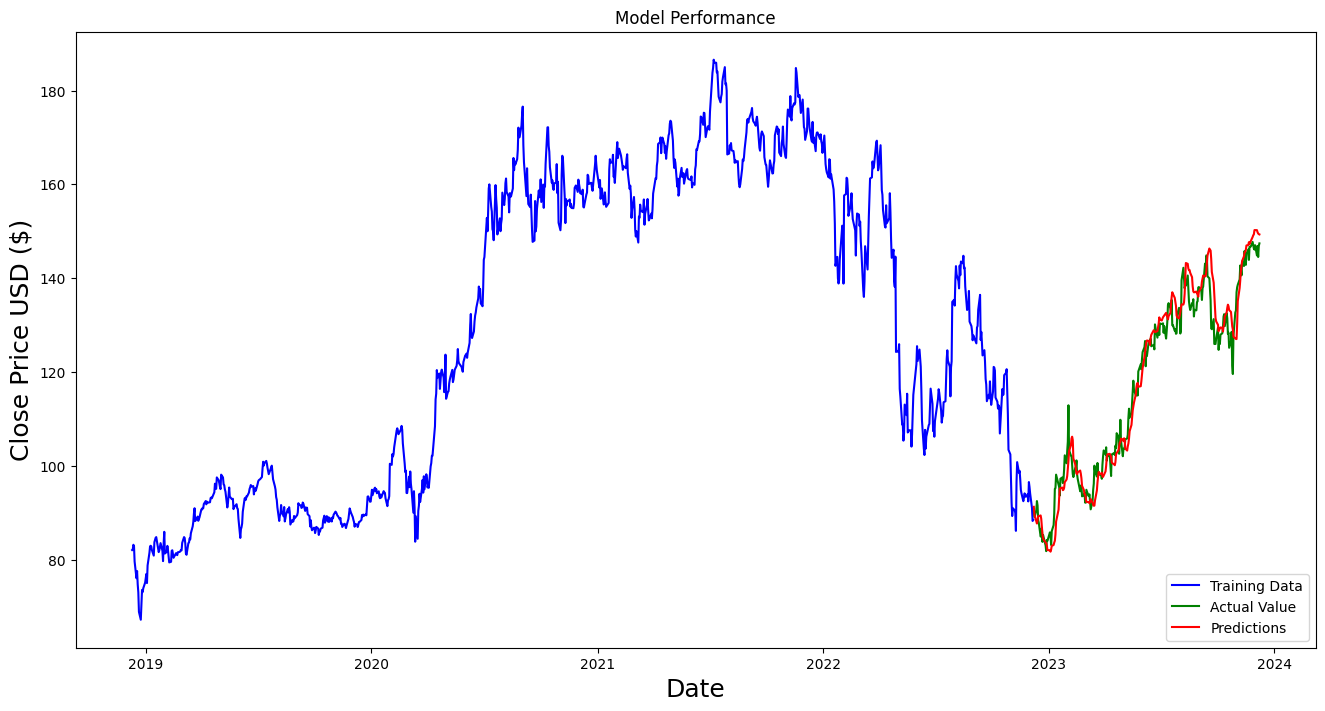

In [ ]:
# Creating a dataframe for the actual and predicted values
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions.flatten()  # Flatten predictions array

# Visualizing the data
plt.figure(figsize=(16,8))
plt.title('Model Performance')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price USD ($)', fontsize = 18)

plt.plot(train['Close'], color='blue', label='Training Data')
plt.plot(valid['Close'], color='green', label='Testing Data')
plt.plot(valid['Predictions'], color='red', label='Predicted Values')

plt.legend(['Training Data', 'Actual Value', 'Predictions'], loc = 'lower right')
plt.show()

In [ ]:
# Display the valid and predicted prices
print(valid[['Close', 'Predictions']])

                 Close  Predictions
Date                               
2022-12-08   90.349998    91.267006
2022-12-09   89.089996    89.546898
2022-12-12   90.550003    88.137131
2022-12-13   92.489998    87.704498
2022-12-14   91.580002    88.407883
...                ...          ...
2023-12-04  144.839996   150.243652
2023-12-05  146.880005   149.793823
2023-12-06  144.520004   149.526596
2023-12-07  146.880005   149.385178
2023-12-08  147.419998   149.329102

[252 rows x 2 columns]


In [ ]:
# Calculating MSE
mse = mean_squared_error(valid['Close'], valid['Predictions'])

# Calculating RMSE
rmse = np.sqrt(mse)

# Calculating MAE
mae = mean_absolute_error(valid['Close'], valid['Predictions'])

# Calculating MAPE (avoid division by zero errors)
mape = np.mean(np.abs((valid['Close'] - valid['Predictions']) / valid['Close'])) * 100

# Calculating R-squared
r_squared = r2_score(valid['Close'], valid['Predictions'])

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("R-squared:", r_squared)

Mean Squared Error (MSE): 16.966021386950853
Root Mean Squared Error (RMSE): 4.118983052520471
Mean Absolute Error (MAE): 3.212109641423301
Mean Absolute Percentage Error (MAPE): 2.760301514236941
R-squared: 0.9534091336732872


### Forecasting

In [ ]:
# Forecasting based on the sequence_length
prev_x_days = data['Close'].tail(sequence_length).values
prev_x_days_scaled = scaler.transform(prev_x_days.reshape(-1, 1))

# List to hold the predictions
forecasted_values = []

current_batch = prev_x_days_scaled.reshape((1, sequence_length, 1))

# Number of days to forecast
num_forecast_days = 30

for i in range(num_forecast_days):  # Forecasting 30 days
    # Get the prediction value for the first timestamp
    current_pred = best_model.predict(current_batch)[0]

    # Append the prediction into the array
    forecasted_values.append(current_pred[0])  # Ensure appending only the scalar value

    # Use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

# Inverse transform to get the actual forecast values
forecasted_values = scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1))

date_column = 'Date'

# # Create a date index for the predictions
if date_column in data.columns:
  last_date = pd.to_datetime(data[date_column].iloc[-1])
else:
#     # If no date column, assuming the frequency is daily
  last_date = pd.to_datetime('today')  # or use a specific date as a string

forecast_dates = pd.date_range(start=last_date, periods=num_forecast_days)

# Prepare the forecast dataframe
forecast = pd.DataFrame(data=forecasted_values.flatten(), index=forecast_dates, columns=['Forecast'])

1/1 [==============================] - 0s 17ms/step


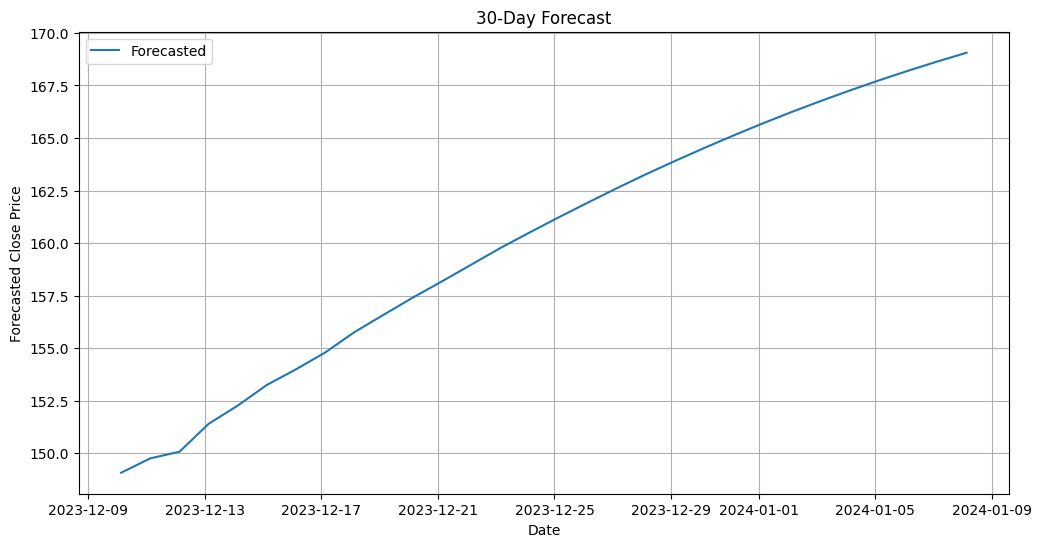

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(forecast.index, forecast['Forecast'], label='Forecasted')

plt.title('30-Day Forecast')
plt.xlabel('Date')
plt.ylabel('Forecasted Close Price')
plt.legend()
plt.grid(True)
plt.show()

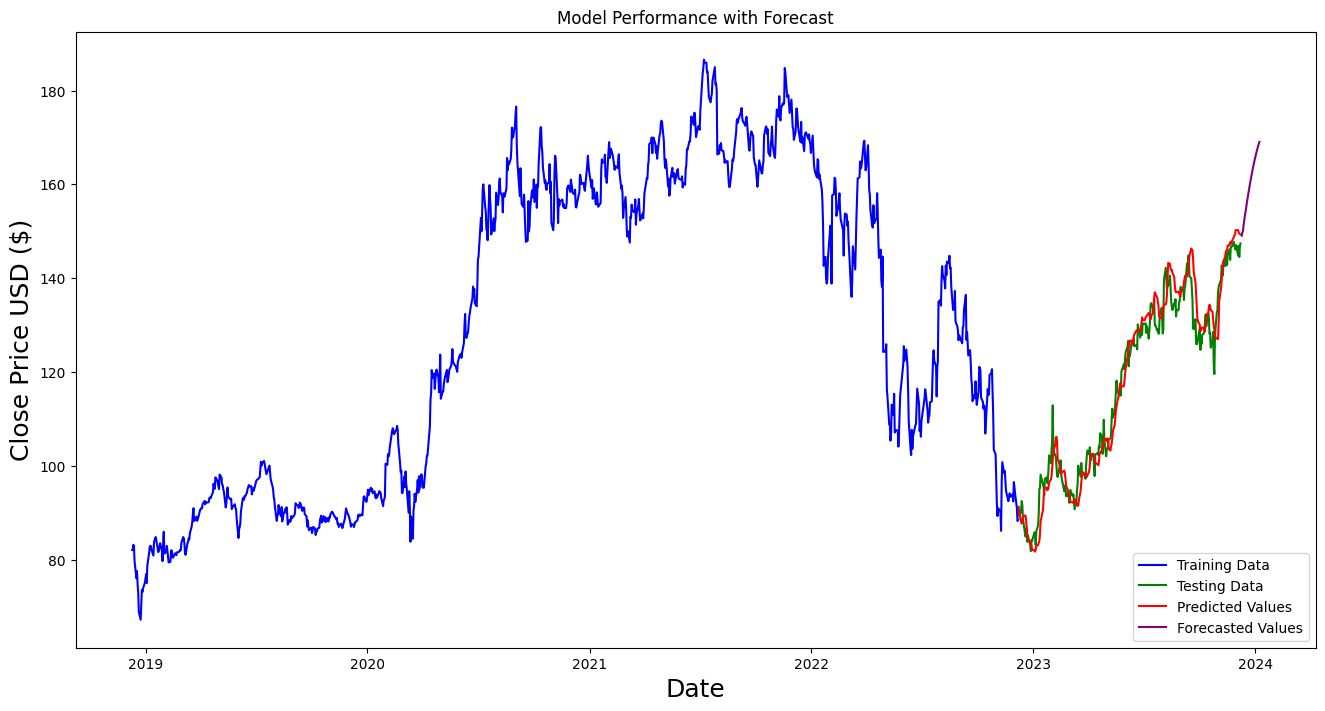

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Model Performance with Forecast')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price USD ($)', fontsize = 18)

# Plotting the existing data
plt.plot(train['Close'], color='blue', label='Training Data')
plt.plot(valid['Close'], color='green', label='Testing Data')
plt.plot(valid['Predictions'], color='red', label='Predicted Values')

# Plotting the forecast data
plt.plot(forecast['Forecast'], color='purple', label='Forecasted Values')
# plt.plot(forecast.index, forecast['Forecast'], color='purple', marker='', linestyle='-', linewidth=2, markersize=3, label='Forecasted Values')

plt.legend(['Training Data', 'Testing Data', 'Predicted Values', 'Forecasted Values'], loc='lower right')
plt.show()